<center><h1> POKEMON CLASSIFIER </h1></center>

In [69]:
#importing neccessary modules
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [70]:
p = Path("./dataset/")
dirs = p.glob("*")

image_data = []
labels = []

labels_dic = {"Pikachu":0,"Bulbasaur":1,"Meowth":2}
labels2pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Meowth"}

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1] 
    cnt = 0
    print(folder_dir)
    
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path,target_size = (40,40))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dic[label])
        
        cnt += 1
    print(cnt)
        
    


dataset\Bulbasaur
176
dataset\Meowth
70
dataset\Pikachu
199


# VISUALIZATION

In [145]:
import numpy as np

In [146]:
import random
random.seed(10)

In [147]:
X = np.array(image_data)
Y = np.array(labels)

from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state = 2)

X = X/255.0

In [148]:
print(X.shape)
print(Y.shape)

(445, 40, 40, 3)
(445,)


In [149]:
def drawImg(img,label):
    plt.title(labels2pokemon[label])
    plt.imshow(img)
    plt.axis("off")
    plt.style.use('seaborn')
    plt.show()

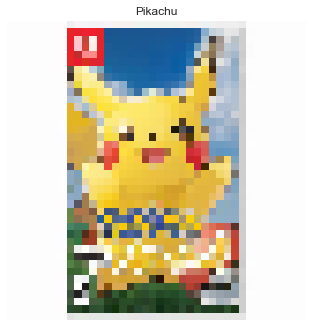

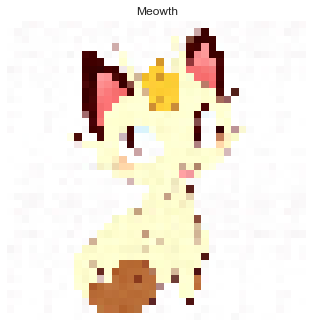

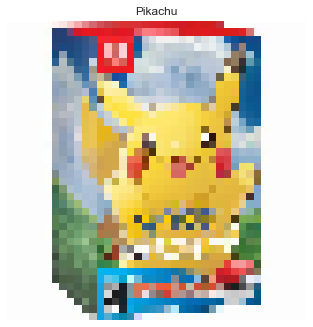

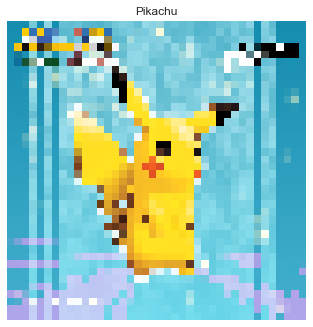

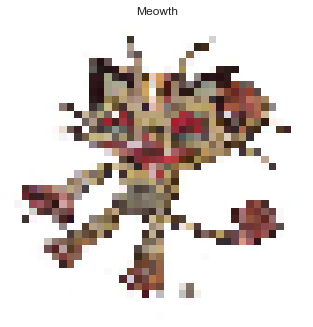

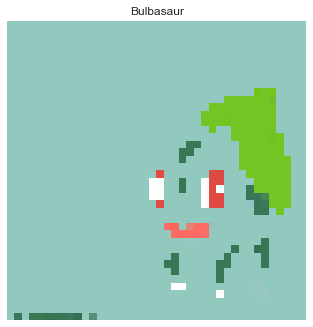

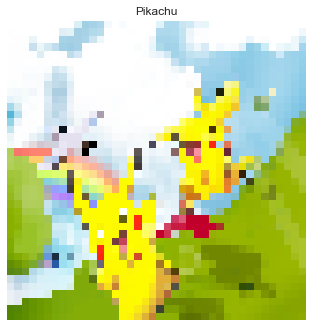

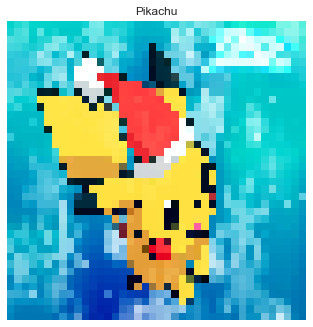

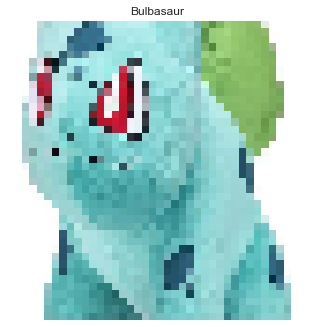

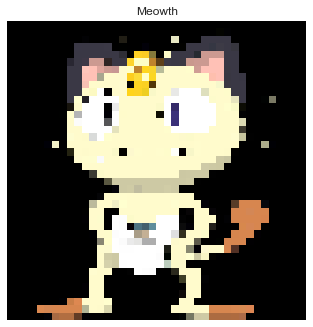

In [150]:

for i in range(10):
    drawImg(X[i],Y[i])
    
    
    
    
    
    

In [151]:
#create training and testing set

split = int(X.shape[0]*0.8)
print(X.shape[0],split)

X_  = np.array(X)
Y_ = np.array(Y)

#training
X = X_[:split,:]
Y = Y_[:split]

#test
X_Test = X_[split:,:]
Y_Test = Y_[split:]

print(X.shape,Y.shape)
print(X_Test.shape,Y_Test.shape)

445 356
(356, 40, 40, 3) (356,)
(89, 40, 40, 3) (89,)


In [152]:
def softmax(a):
    e_pa = np.exp(a)
    ans  = e_pa/np.sum(e_pa,axis = 1,keepdims = True)
    return ans

In [153]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {} #dictionary
        
        #First Layer
        model['w1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        #Second Layer
        model['w2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        #Third Layer
        model['w3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))
        
        
        self.model = model
        self.activation_outputs = None
        
    def forward(self,x):
        w1,w2,w3 = self.model['w1'],self.model['w2'],self.model['w3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,w1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1,w2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,w3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
   
    def backward(self,x,y,alpha = 0.001):
        w1,w2,w3 = self.model['w1'],self.model['w2'],self.model['w3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        a1,a2,y_ = self.activation_outputs
       
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis = 0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,w3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis = 0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,w2.T)
        dw1 = np.dot(x.T,delta1)
        db1 = np.sum(delta1,axis = 0)
        
        #gradient descent
        self.model['w1'] -= alpha*dw1 
        self.model['b1'] -= alpha*db1 
        
        self.model['w2'] -= alpha*dw2 
        self.model['b2'] -= alpha*db2 
        
        self.model['w3'] -= alpha*dw3 
        self.model['b3'] -= alpha*db3 
    
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis = 1)
    def summary(self):
        w1,w2,w3 = self.model['w1'],self.model['w2'],self.model['w3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        a1,a2,y_ = self.activation_outputs
        
        print("w1 ",w1.shape)
        print("a1 ",a1.shape)
        
        print("w2 ",w2.shape)
        print("a2 ",a2.shape)
        
        print("w3 ",w3.shape)
        print("Y_ ",y_.shape)
      

In [154]:
def loss(y_oht,p): 
    l  = -np.mean(y_oht*np.log(p))
    return l
def one_hot(y,depth):
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [155]:
model  = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3)

In [156]:
def train(X,Y,model,epochs,alpha,logs=True):
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        training_loss.append(l)
        model.backward(X,Y_OHT,alpha)
        
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l))
            
    
    return training_loss

In [157]:
X = X.reshape(X.shape[0],-1)
X_Test = X_Test.reshape(X_Test.shape[0],-1)

print(X.shape,X_Test.shape)

(356, 4800) (89, 4800)


In [158]:
losses = train(X,Y,model,500,0.0002)

Epoch 0 Loss 3.1966
Epoch 50 Loss 0.2660
Epoch 100 Loss 0.1462
Epoch 150 Loss 0.1006
Epoch 200 Loss 0.0786
Epoch 250 Loss 0.0644
Epoch 300 Loss 0.0540
Epoch 350 Loss 0.0463
Epoch 400 Loss 0.0410
Epoch 450 Loss 0.0369


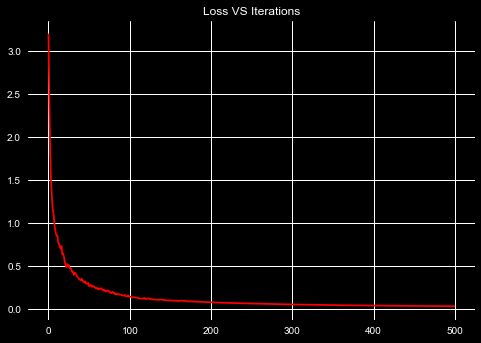

In [164]:
plt.style.use('dark_background')
plt.plot(losses,color = 'red')
plt.title("Loss VS Iterations")
plt.show()


In [166]:
def accuracy(X,Y,model):
    return np.sum(model.predict(X)==Y)/Y.shape[0]

print(accuracy(X,Y,model))
print(accuracy(X_Test,Y_Test,model))
    

0.9887640449438202
0.6404494382022472


# THIS LESSER ACCURACY IS JUST BECAUSE OF OVERFITTING

In [168]:
# know about the confusion matrix

from sklearn.metrics import confusion_matrix
from visualize import plot_confusion_matrix

In [169]:
outputs = model.predict(X)
cnf = confusion_matrix(outputs,Y)
print(cnf)

[[159   1   1]
 [  1 133   0]
 [  0   1  60]]


Confusion matrix, without normalization
[[159   1   1]
 [  1 133   0]
 [  0   1  60]]


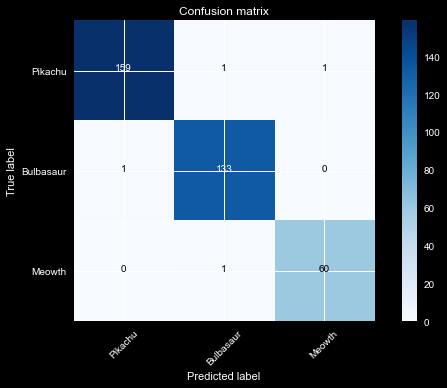

In [170]:
plot_confusion_matrix(cnf,classes = ["Pikachu","Bulbasaur","Meowth"],title = "Confusion matrix")

In [171]:
from sklearn.metrics import classification_report

In [172]:
print(classification_report(outputs,Y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.99      0.99      0.99       134
           2       0.98      0.98      0.98        61

    accuracy                           0.99       356
   macro avg       0.99      0.99      0.99       356
weighted avg       0.99      0.99      0.99       356



In [173]:
test_outputs = model.predict(X_Test)
cnf1 = confusion_matrix(test_outputs,Y_Test)
print(cnf1)

[[29 10  4]
 [ 5 26  3]
 [ 5  5  2]]


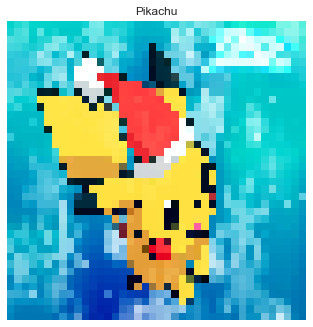

Predicted output is Bulbasaur


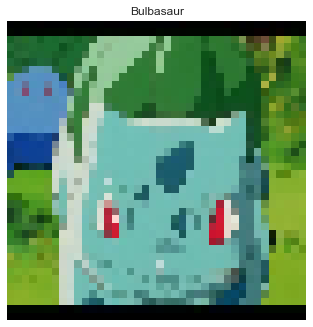

Predicted output is Meowth


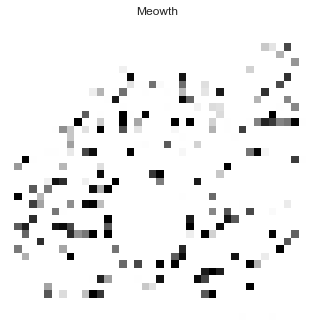

Predicted output is Pikachu


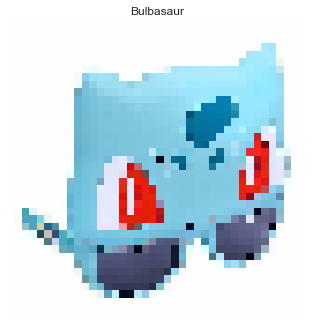

Predicted output is Pikachu


In [179]:
for i in range(Y.shape[0]):
    if(Y[i]!=outputs[i]):
        drawImg(X[i].reshape(40,40,3),Y[i])
        print("Predicted output is %s"%(labels2pokemon[outputs[i]]))